# RL and Advanced DL: Домашнее задание 2

## Часть 1: крестики-нолики при помощи Q-обучения

Студент Черников Дмитрий, ML-32

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import random
import numpy as np
import scipy as sp
import pandas as pd
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
from IPython.display import clear_output
from tqdm import tqdm
import pickle
import copy

from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple, defaultdict, Counter
from itertools import count

from tictactoe import TicTacToe

import cProfile
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('text', usetex=True)
rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
rc('text.latex',preamble=r'\usepackage[russian]{babel}')
rc('figure', **{'dpi': 300})

## Реализуем крестики-нолики

In [2]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

In [3]:
def run_episode(env, pi1, pi2, verbose=False):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    done = False
    reward = 0
    env.reset()
    state, actions = env.getHash(), env.getEmptySpaces()
    while not done:
        turn = env.curTurn
        if turn == 1:
            a = pi1.action(state, len(actions))
        else:
            a = pi2.action(state, len(actions))
           
        (next_state, actions, _), reward, done, _ = env.step(actions[a])

        if turn == 1:
            pi1.collect(state, a, reward, next_state, done)
            pi2.collect(state, -1, 0, next_state, done)
        else:
            pi1.collect(state, -1, 0, next_state, done)
            pi2.collect(state, a, -1 * reward, next_state, done)
        
        state = next_state

        if verbose:
            env.printBoard()

    if verbose:
        if reward == 1:
            print("Крестики выиграли!")
        if reward == -1:
            print("Нолики выиграли!")
        if reward == 0:
            print("Ничья!")
    return reward, env


def run_series(pi1, pi2, n_rows=3, n_cols=3, n_win=3, n_iters=10000, verbose=False):
    results = []
    for i in range(n_iters):
        env = TicTacToe(n_rows=n_rows, n_cols=n_cols, n_win=n_win)
        reward, env = run_episode(env, pi1, pi2, verbose=verbose)
        results.append(reward)
    return np.array(results)

def plot_series_results(results, width=0.1, label=None):
    x = Counter(results)
    s = np.sum(list(x.values()))
    plt.bar(x.keys(), [v/s for v in x.values()], width=width, label=label)
    plt.xticks(ticks=[-1, 0, 1], labels=["Нолик", "Ничья", "Крестик"])
    if label is not None:
        plt.legend()

In [4]:
class RandomPolicy():
    def __init__(self, name=""):
        self.name = name
        
    def action(self, state, n_actions):
        return np.random.randint(n_actions)
    
    def collect(self, state, action, reward, next_state, done):
        pass

In [5]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
run_episode(env, RandomPolicy("X"), RandomPolicy("O"), True)
plt.show()

╭───┬───┬───╮
│   │   │ x │ 
├───┼───┼───┤
│   │   │   │ 
├───┼───┼───┤
│   │   │   │ 
╰───┴───┴───╯
╭───┬───┬───╮
│   │   │ x │ 
├───┼───┼───┤
│   │   │   │ 
├───┼───┼───┤
│   │   │ o │ 
╰───┴───┴───╯
╭───┬───┬───╮
│   │   │ x │ 
├───┼───┼───┤
│   │   │ x │ 
├───┼───┼───┤
│   │   │ o │ 
╰───┴───┴───╯
╭───┬───┬───╮
│   │   │ x │ 
├───┼───┼───┤
│   │ o │ x │ 
├───┼───┼───┤
│   │   │ o │ 
╰───┴───┴───╯
╭───┬───┬───╮
│   │ x │ x │ 
├───┼───┼───┤
│   │ o │ x │ 
├───┼───┼───┤
│   │   │ o │ 
╰───┴───┴───╯
╭───┬───┬───╮
│   │ x │ x │ 
├───┼───┼───┤
│ o │ o │ x │ 
├───┼───┼───┤
│   │   │ o │ 
╰───┴───┴───╯
╭───┬───┬───╮
│ x │ x │ x │ 
├───┼───┼───┤
│ o │ o │ x │ 
├───┼───┼───┤
│   │   │ o │ 
╰───┴───┴───╯
Крестики выиграли!


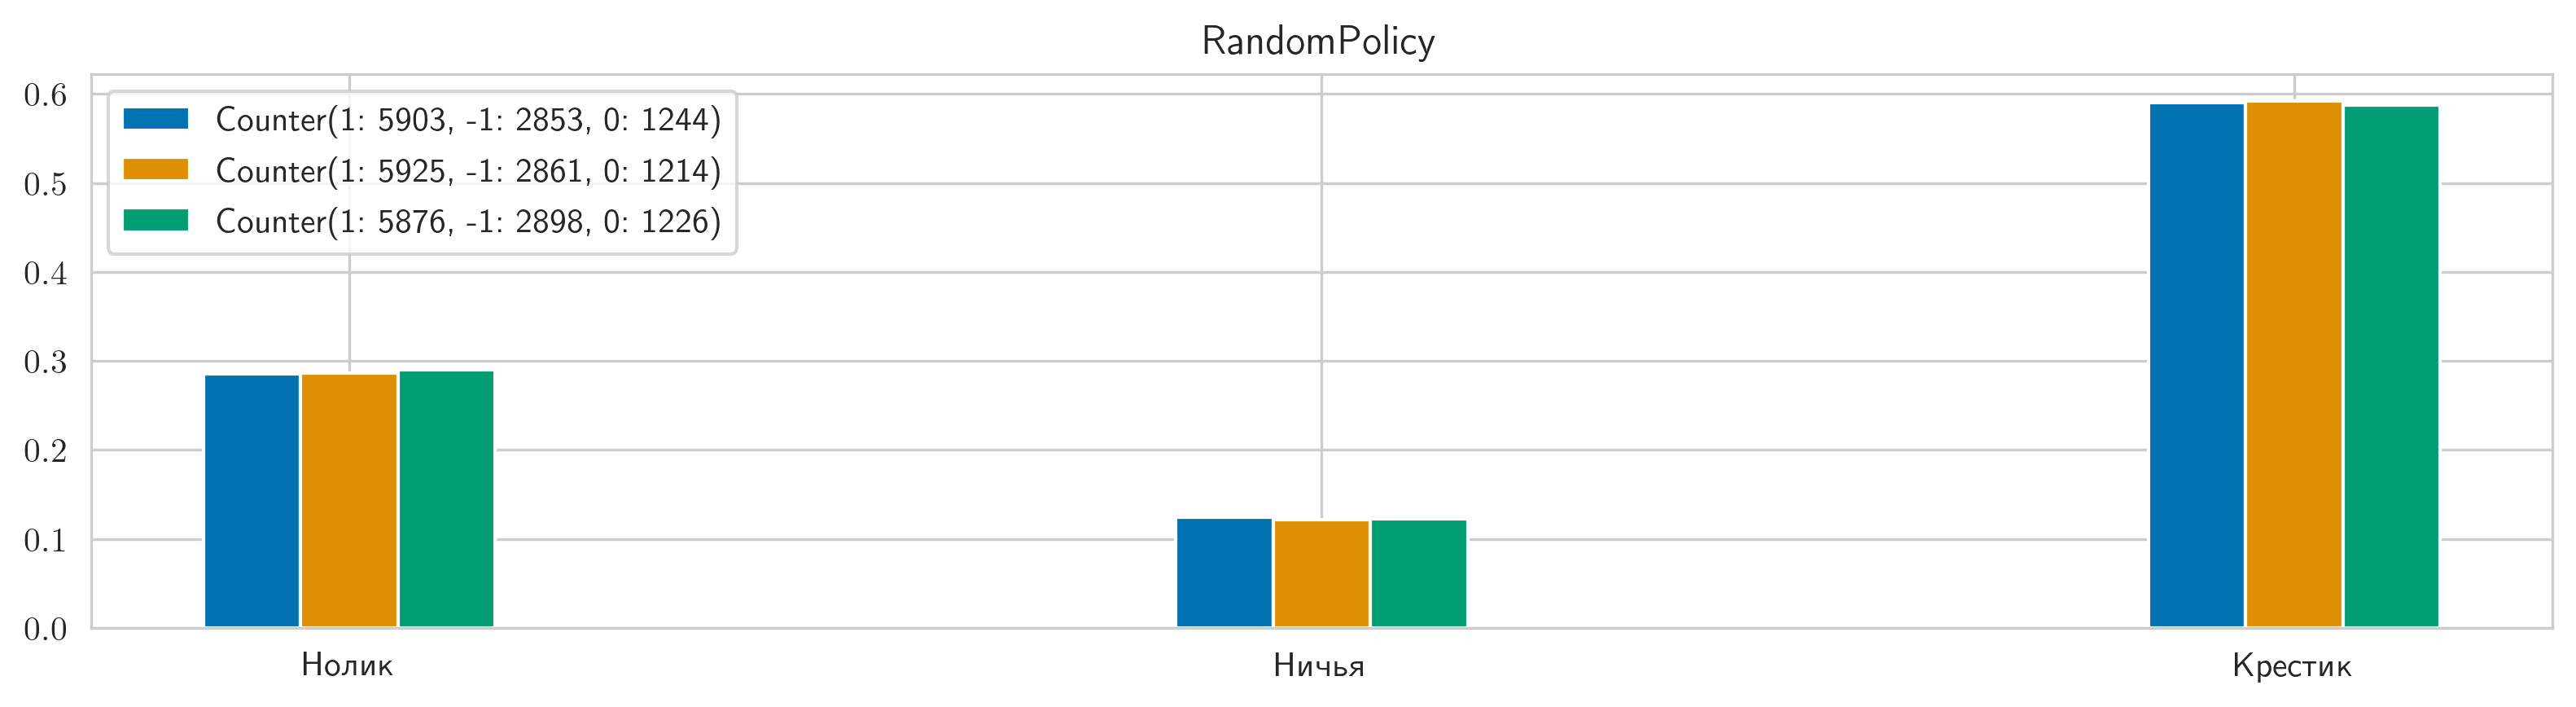

In [6]:
plt.figure(figsize=(13,3))       
witdh = 0.1

results = run_series(RandomPolicy(), RandomPolicy())
plot_series_results(results-witdh, width=witdh, label=f"{Counter(results)}")

results = run_series(RandomPolicy(), RandomPolicy())
plot_series_results(results, width=witdh, label=f"{Counter(results)}")

results = run_series(RandomPolicy(), RandomPolicy())
plot_series_results(results+witdh, width=witdh, label=f"{Counter(results)}")

plt.title("RandomPolicy")

plt.show()

## 1. Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.

In [13]:
class QLearningPolicy():
    def __init__(self, name="", eps=0.95, alpha=0.05, gamma=0.005):
        self.name = name
        self.eps = eps
        self.alpha = alpha
        self.gamma = gamma
        self.Q = defaultdict(lambda: defaultdict(float))
        
    def action(self, state, n_actions):
        state_actions = self.Q[state]
        if np.random.uniform() < self.eps and len(state_actions) > 0:
            return max(state_actions, key=state_actions.get)
        else:
            return np.random.randint(n_actions)
    
    def collect(self, state, action, reward, next_state, done):
        Q_St_next = 0
        next_actions = self.Q[next_state]
        if len(next_actions) > 0:
            Q_St_next = max(self.Q[next_state].values())
        Q_St_At = self.Q[state][action]
        Q_St_At = Q_St_At + self.alpha * (reward + self.gamma * Q_St_next - Q_St_At)
        self.Q[state][action] = Q_St_At


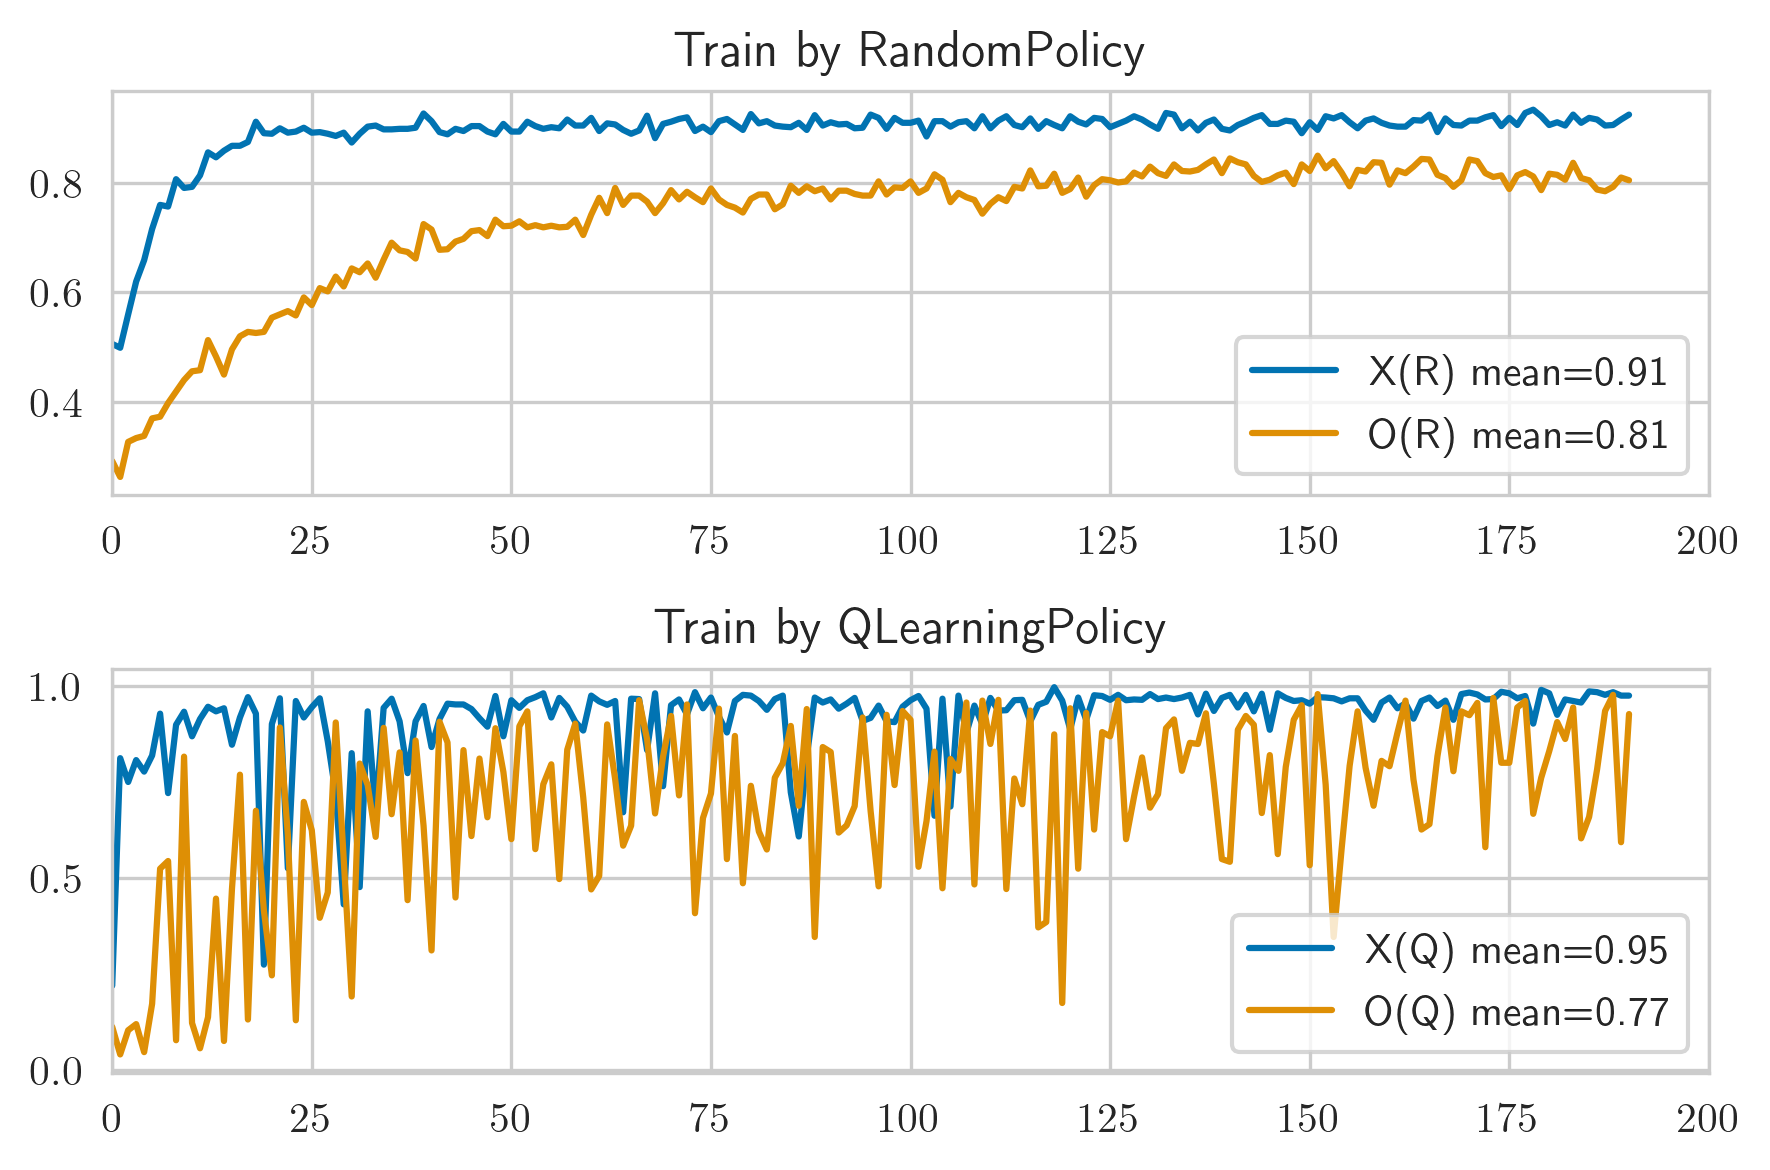

100%|█████████████████████████████████████████| 200/200 [04:06<00:00,  1.23s/it]


In [43]:
SEED = 10
N_ROWS = 3
N_COLS = 3
N_ITERS = 1000
N_EPOCHS = 200

piXR = QLearningPolicy(name="XR")
piOR = QLearningPolicy(name="OR")
piXQ = QLearningPolicy(name="XQ")
piOQ = QLearningPolicy(name="OQ")

historyXR = []
historyXQ = []
historyOR = []
historyOQ = []

plt.figure(figsize=(13,6))


for epoch in tqdm(range(N_EPOCHS)):
    
    results = run_series(piXR, RandomPolicy(), n_iters=N_ITERS, n_rows=N_ROWS, n_cols=N_COLS)
    historyXR.append(Counter(results)[1] / N_ITERS)

    results = run_series(piXQ, QLearningPolicy(), n_iters=N_ITERS, n_rows=N_ROWS, n_cols=N_COLS)
    historyXQ.append(Counter(results)[1] / N_ITERS)

    results = run_series(RandomPolicy(), piOR, n_iters=N_ITERS, n_rows=N_ROWS, n_cols=N_COLS)
    historyOR.append(Counter(results)[-1] / N_ITERS)

    results = run_series(QLearningPolicy(), piOR, n_iters=N_ITERS, n_rows=N_ROWS, n_cols=N_COLS)
    historyOQ.append(Counter(results)[-1] / N_ITERS)
    
    if epoch % 10 == 0:
        clear_output()
        
        plt.subplot(211)

        plt.plot(historyXR, label=f"X(R) mean={np.mean(historyXR[-100:]):0.2}")
        plt.plot(historyOR, label=f"O(R) mean={np.mean(historyOR[-100:]):0.2}")
        plt.xlim((0, N_EPOCHS))
        plt.title("Train by RandomPolicy")
        plt.legend(loc="lower right")

        plt.subplot(212)
        plt.plot(historyXQ, label=f"X(Q) mean={np.mean(historyXQ[-100:]):0.2}")
        plt.plot(historyOQ, label=f"O(Q) mean={np.mean(historyOQ[-100:]):0.2}")
        plt.xlim((0, N_EPOCHS))
        plt.title("Train by QLearningPolicy")
        plt.legend(loc="lower right")
        
        plt.tight_layout()
        plt.show()



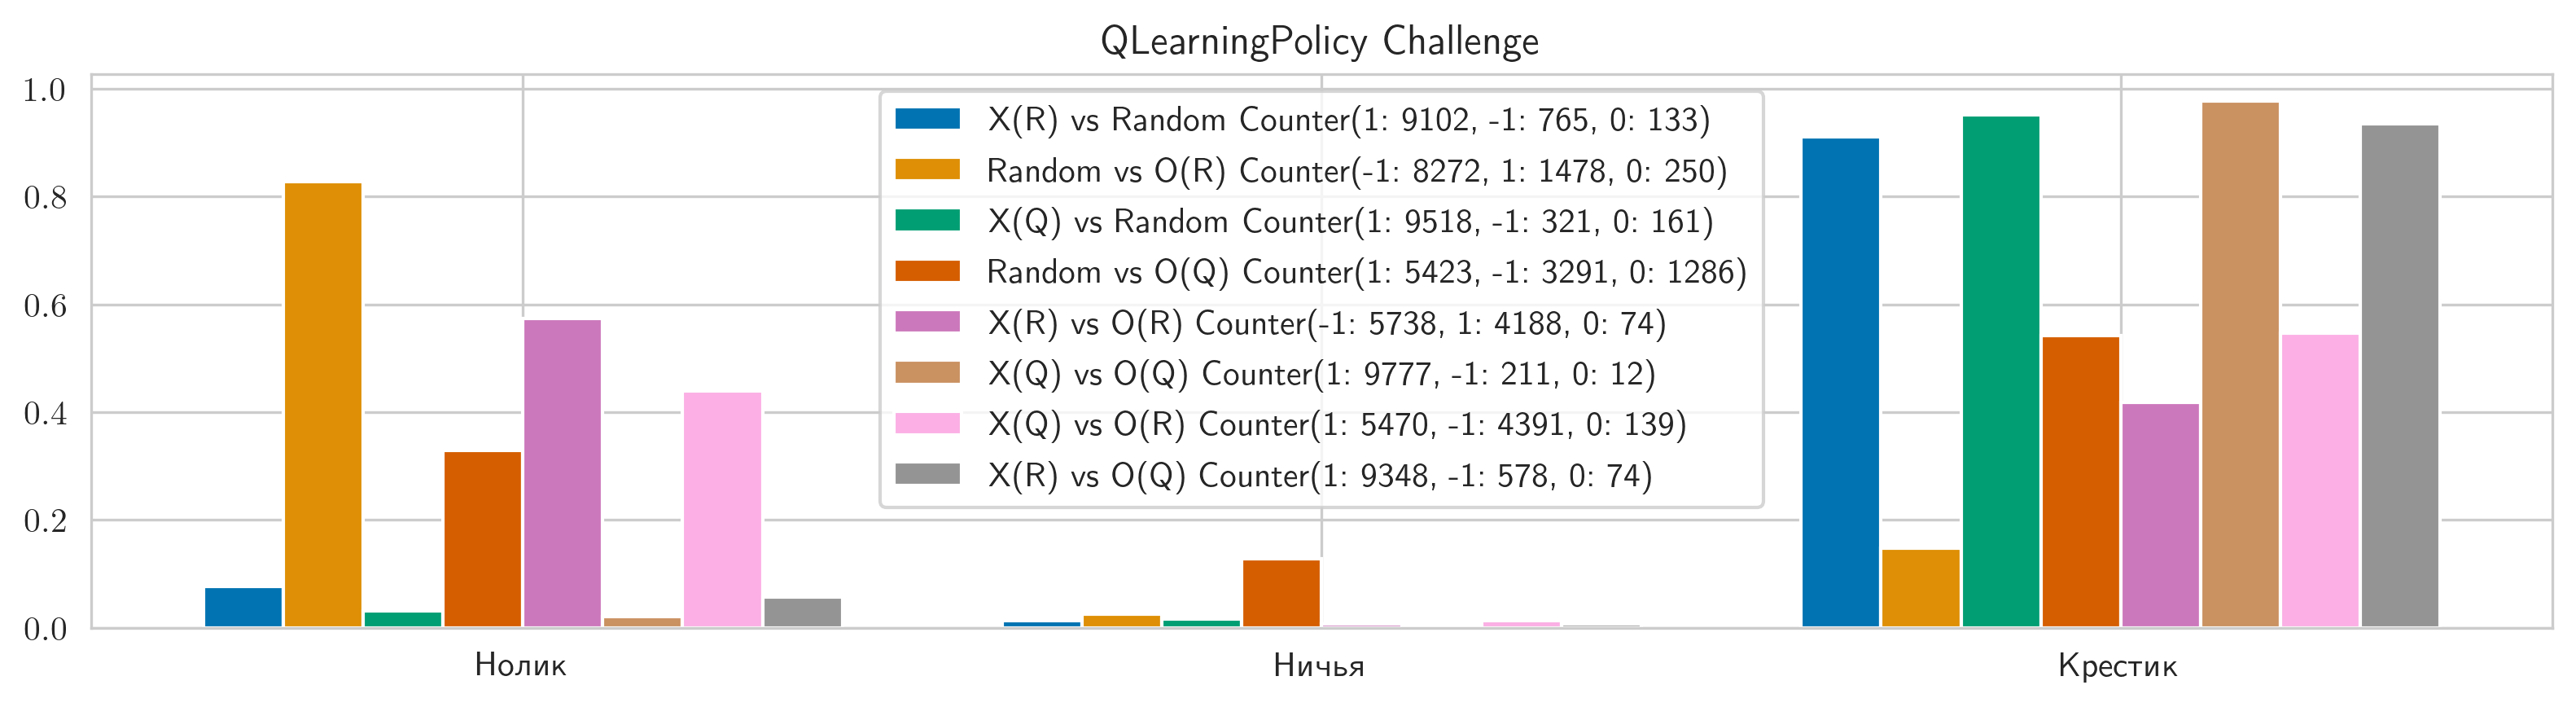

In [44]:
plt.figure(figsize=(13,3))       
witdh = 0.1

results = run_series(piXR, RandomPolicy())
plot_series_results(results-7/2*witdh, width=witdh, label=f"X(R) vs Random {Counter(results)}")

results = run_series(RandomPolicy(), piOR)
plot_series_results(results-5/2*witdh, width=witdh, label=f"Random vs O(R) {Counter(results)}")

results = run_series(piXQ, RandomPolicy())
plot_series_results(results-3/2*witdh, width=witdh, label=f"X(Q) vs Random {Counter(results)}")

results = run_series(RandomPolicy(), piOQ)
plot_series_results(results-1/2*witdh, width=witdh, label=f"Random vs O(Q) {Counter(results)}")

results = run_series(piXR, piOR)
plot_series_results(results+1/2*witdh, width=witdh, label=f"X(R) vs O(R) {Counter(results)}")

results = run_series(piXQ, piOQ)
plot_series_results(results+3/2*witdh, width=witdh, label=f"X(Q) vs O(Q) {Counter(results)}")

results = run_series(piXQ, piOR)
plot_series_results(results+5/2*witdh, width=witdh, label=f"X(Q) vs O(R) {Counter(results)}")

results = run_series(piXR, piOQ)
plot_series_results(results+7/2*witdh, width=witdh, label=f"X(R) vs O(Q) {Counter(results)}")

plt.legend(loc="upper center")
plt.title("QLearningPolicy Challenge")
plt.show()

## 2. Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

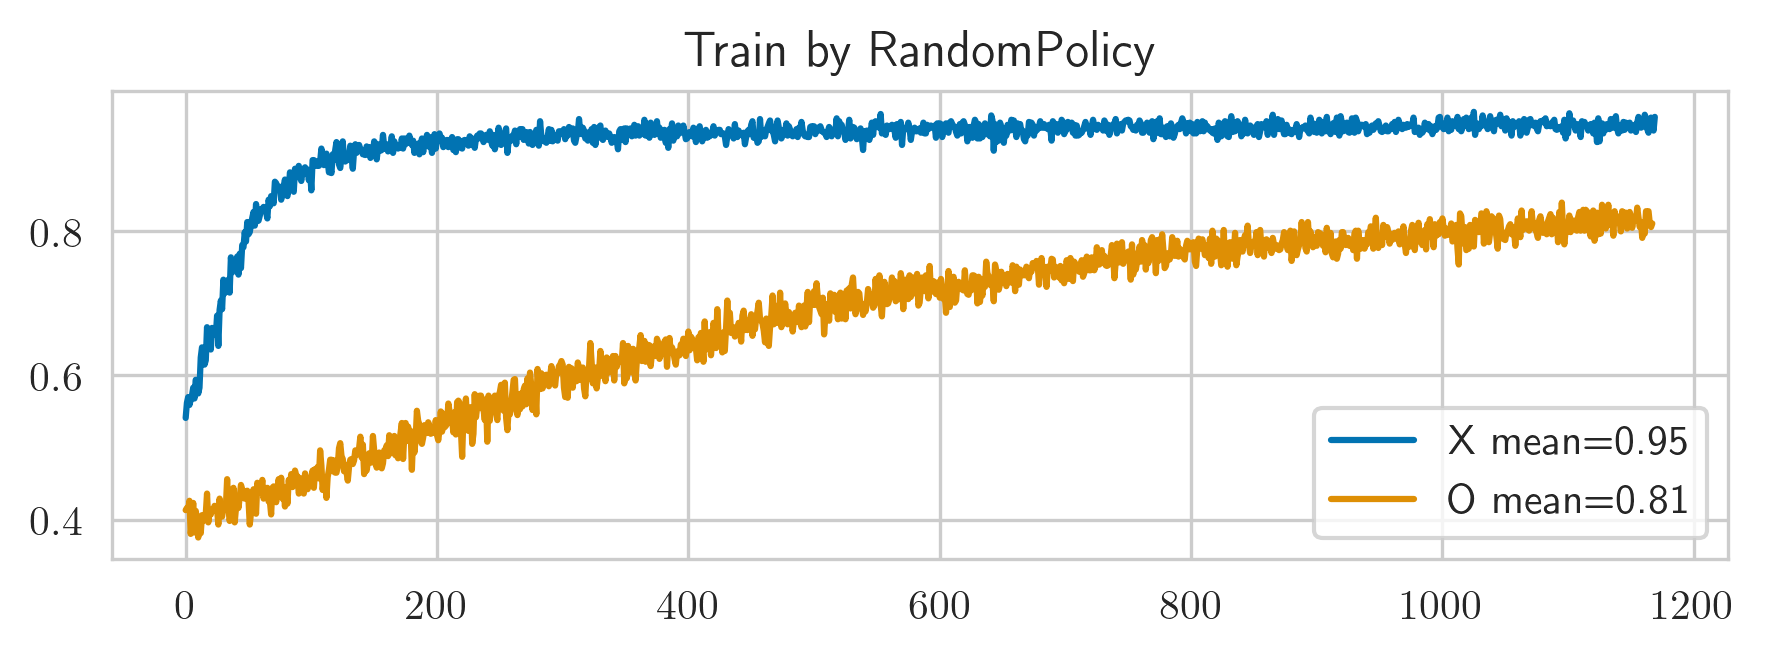

100%|█████████████████████████████████████████| 500/500 [07:50<00:00,  1.06it/s]


In [58]:
SEED = 10
N_WIN = 4
N_ROWS = 4
N_COLS = 4
N_ITERS = 1000
N_EPOCHS = 1000

piX = QLearningPolicy(name="X")
piO = QLearningPolicy(name="O")

historyX = []
historyO = []

plt.figure(figsize=(13,6))

for epoch in tqdm(range(N_EPOCHS)):
    
    results = run_series(piX, RandomPolicy(), n_iters=N_ITERS, n_rows=N_ROWS, n_cols=N_COLS)
    historyX.append(Counter(results)[1] / N_ITERS)

    results = run_series(RandomPolicy(), piO, n_iters=N_ITERS, n_rows=N_ROWS, n_cols=N_COLS)
    historyO.append(Counter(results)[-1] / N_ITERS)

    if epoch % 10 == 0:
        clear_output()
        
        plt.subplot(211)
        plt.plot(historyX, label=f"X mean={np.mean(historyX[-100:]):0.2}")
        plt.plot(historyO, label=f"O mean={np.mean(historyO[-100:]):0.2}")
        plt.title("Train by RandomPolicy")
        plt.legend(loc="lower right")

        plt.tight_layout()
        plt.show()

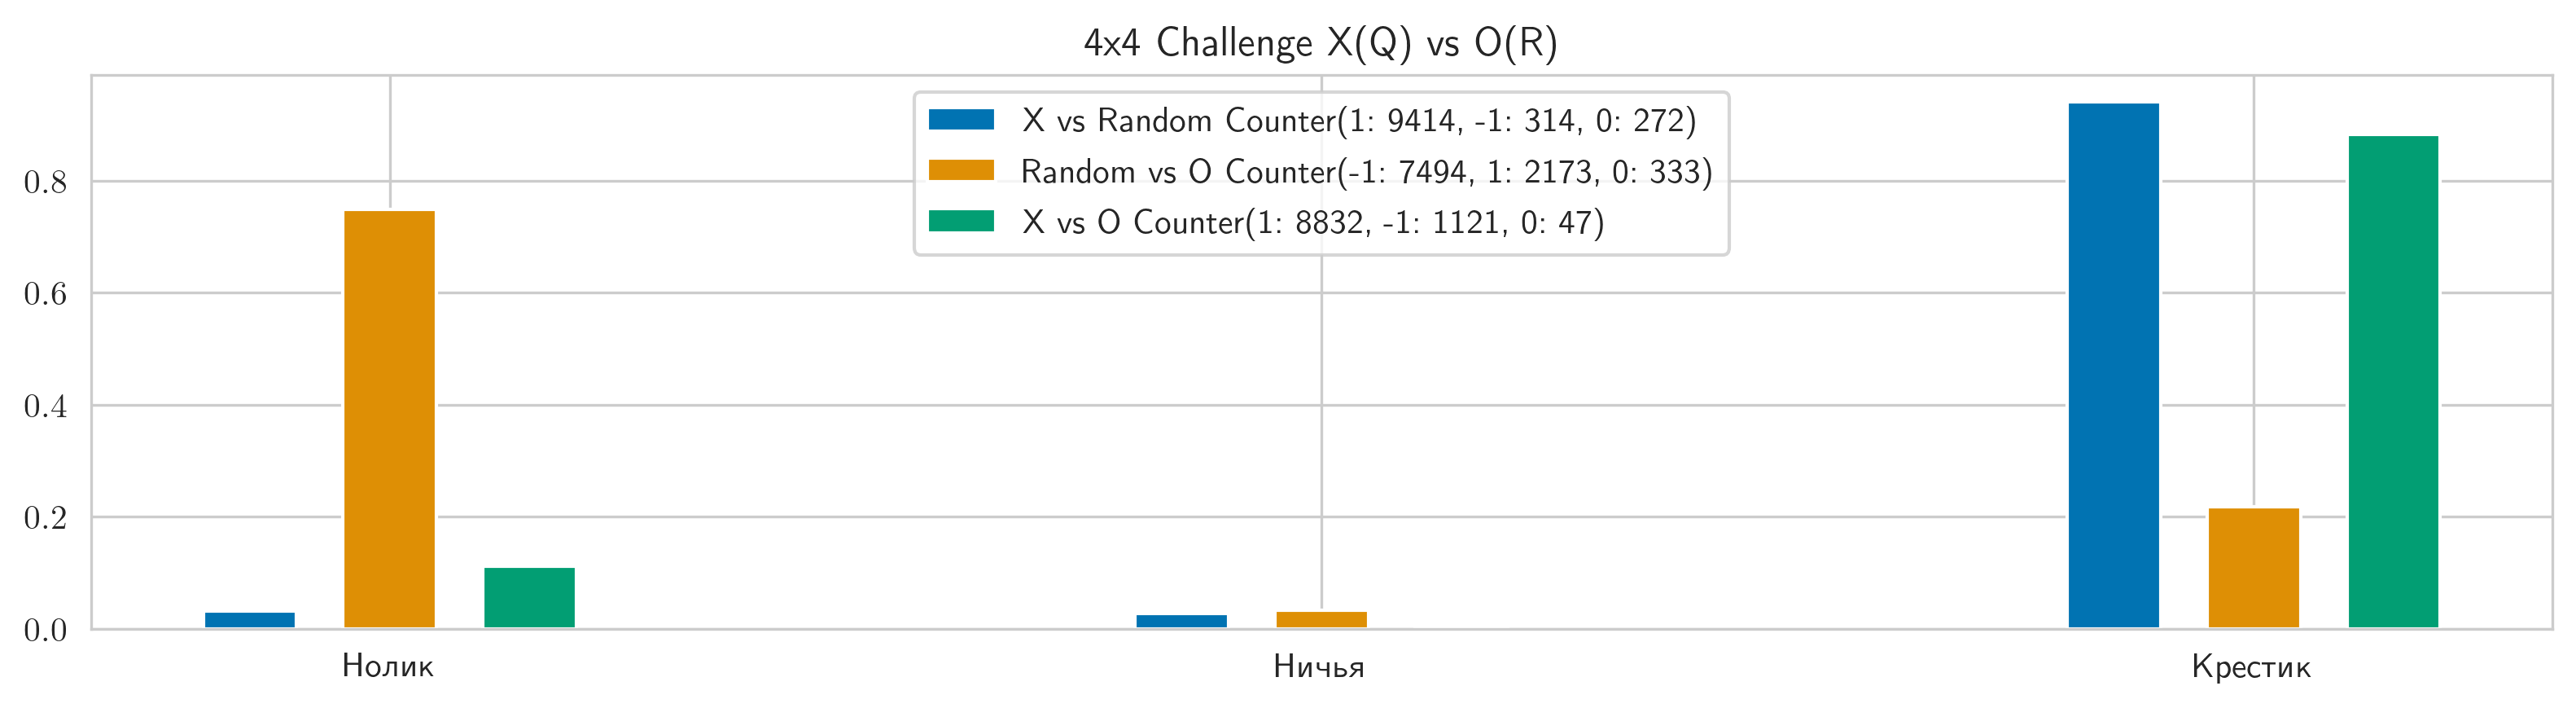

In [64]:
plt.figure(figsize=(13,3))       
witdh = 0.1

results = run_series(piX, RandomPolicy())
plot_series_results(results-3/2*witdh, width=witdh, label=f"X vs Random {Counter(results)}")

results = run_series(RandomPolicy(), piO)
plot_series_results(results, width=witdh, label=f"Random vs O {Counter(results)}")

results = run_series(piX, piO)
plot_series_results(results+3/2*witdh, width=witdh, label=f"X vs O {Counter(results)}")

plt.legend(loc="upper center")
plt.title("4x4 Challenge X(Q) vs O(R)")
plt.show()

# Выводы

- крестик начинает и выигрывает
- крестик учится быстрее
- обучение на случайных данных более ровное
- крестик лучше обучается на сильном сопернике
- нолик лучше обучается на случайных данных